In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import os
import torch
from kan import KAN
import time
import warnings
warnings.filterwarnings(
    "ignore",
    "CUDA initialization: Unexpected error from cudaGetDeviceCount"
)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Use CPU for this example
print(f"\n Using device: {device} \n")


 Using device: cpu 



#### Utils

In [2]:
import ltn

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT_DDoS_Connect_Flood = ltn.Constant(torch.tensor([1, 0, 0, 0, 0, 0]))
l_MQTT_DDoS_Publish_Flood = ltn.Constant(torch.tensor([0, 1, 0, 0, 0, 0]))
l_MQTT_DoS_Connect_Flood = ltn.Constant(torch.tensor([0, 0, 1, 0, 0, 0]))
l_MQTT_DoS_Publish_Flood = ltn.Constant(torch.tensor([0, 0, 0, 1, 0, 0]))
l_MQTT_Malformed_Data = ltn.Constant(torch.tensor([0, 0, 0, 0, 1, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 0, 0, 0, 0, 1]))


def load_csv_data(input_folder: str,
                  train_fname: str,
                  test_fname: str):
    """
    Reads train & test CSVs from disk.
    
    Returns:
      train_df, test_df (both pandas.DataFrame)
    """
    train_path = os.path.join(input_folder, train_fname)
    test_path  = os.path.join(input_folder, test_fname)
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
    return train_df, test_df


def extract_features_labels(df: pd.DataFrame):
    """
    Splits a DataFrame into numpy feature array X and label vector y.
    
    The last column is the label.
    """
    X = df.iloc[:, :-1].values
    y = df.iloc[:,  -1].values
    return X, y

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=64,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]
            ############################################################
            # Check if any class is missing in the batch
            # present_classes = np.unique(labels.cpu().numpy())
            # all_classes = np.arange(len(label_mapping))  # Adjust based on number of classes
            # missing_classes = set(all_classes) - set(present_classes)
            #
            # if missing_classes:
            #     print(f"Batch {start_idx // self.batch_size} is missing classes {missing_classes}")
            ############################################################
            yield data, labels


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """

    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)  # 计算并返回与给定类标签l对应的概率值
        return out


class MultiKANModel(torch.nn.Module):
    def __init__(self, kan):
        """
        Wrap an already built MultKAN instance.
        Args:
            kan: a MultKAN model (which has attributes such as act_fun, symbolic_fun, node_bias, node_scale,
                 subnode_bias, subnode_scale, depth, width, mult_homo, mult_arity, input_id, symbolic_enabled, etc.)
        """
        super(MultiKANModel, self).__init__()
        self.kan = kan

    def forward(self, x, training=False, singularity_avoiding=False, y_th=10.):
        # Select input features according to input_id
        x = x[:, self.kan.input_id.long()]
        # Loop through each layer
        for l in range(self.kan.depth):
            # Get outputs from the numerical branch (KANLayer) of current layer
            x_numerical, preacts, postacts_numerical, postspline = self.kan.act_fun[l](x)
            # Get output from the symbolic branch if enabled
            if self.kan.symbolic_enabled:
                x_symbolic, postacts_symbolic = self.kan.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
            # Sum the numerical and symbolic outputs
            x = x_numerical + x_symbolic

            # Subnode affine transformation
            x = self.kan.subnode_scale[l][None, :] * x + self.kan.subnode_bias[l][None, :]

            # Process multiplication nodes
            dim_sum = self.kan.width[l+1][0]
            dim_mult = self.kan.width[l+1][1]
            if dim_mult > 0:
                if self.kan.mult_homo:
                    for i in range(self.kan.mult_arity-1):
                        if i == 0:
                            x_mult = x[:, dim_sum::self.kan.mult_arity] * x[:, dim_sum+1::self.kan.mult_arity]
                        else:
                            x_mult = x_mult * x[:, dim_sum+i+1::self.kan.mult_arity]
                else:
                    for j in range(dim_mult):
                        acml_id = dim_sum + int(np.sum(self.kan.mult_arity[l+1][:j]))
                        for i in range(self.kan.mult_arity[l+1][j]-1):
                            if i == 0:
                                x_mult_j = x[:, [acml_id]] * x[:, [acml_id+1]]
                            else:
                                x_mult_j = x_mult_j * x[:, [acml_id+i+1]]
                        if j == 0:
                            x_mult = x_mult_j
                        else:
                            x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                # Concatenate sum and mult parts
                x = torch.cat([x[:, :dim_sum], x_mult], dim=1)

            # Node affine transformation
            x = self.kan.node_scale[l][None, :] * x + self.kan.node_bias[l][None, :]

        # Final x corresponds to the logits output of the whole model
        return x


def save_model(model, model_save_folder, model_name):
    """
    Save the model to disk.
    """
    torch.save(model.state_dict(), os.path.join(model_save_folder, model_name))

    print(f"Model saved to {os.path.join(model_save_folder, model_name)}")


def load_model_state(infer_model, model_save_folder, model_name):
    """
    Load the model from disk.
    """
    checkpoint = torch.load(
        os.path.join(model_save_folder, model_name),
        map_location=device,
        weights_only=True     # <-- only load tensor weights, no pickle objects
    )
    infer_model.load_state_dict(checkpoint)
    infer_model.eval()
    return infer_model


def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples


def compute_sat_rule1(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
		)
	return sat_level



#### Tune

##### Load data

In [3]:
# Load data
input_folder = '/home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/input_files'
train_fname = 'logiKNet_train_35945.csv'
test_fname = 'logiKNet_test_3994.csv'

train_df, test_df = load_csv_data(input_folder, train_fname, test_fname)
# Extract features and labels   
X_train, y_train = extract_features_labels(train_df)
X_test, y_test = extract_features_labels(test_df)

dataset_numeric = {
    'train_input': torch.tensor(X_train, dtype=torch.float32, device=device),
    'train_label': torch.tensor(y_train, dtype=torch.long, device=device),
    'test_input': torch.tensor(X_test, dtype=torch.float32, device=device),
    'test_label': torch.tensor(y_test, dtype=torch.long, device=device)
}

train_loader = DataLoader(
    dataset_numeric['train_input'],
    dataset_numeric['train_label'], 
    batch_size=len(X_train), 
    shuffle=True
    )
test_loader = DataLoader(
    dataset_numeric['test_input'],
    dataset_numeric['test_label'],
    # batch_size=32,
    shuffle=False
    )


##### load pre-trained models (LogiKNet/ H-LogiKNet)

In [4]:
model_state_folder = '/home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/model_weights'

logiKNet_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
logiKNet_infer = load_model_state(logiKNet_infer, model_state_folder, 'logiKNet.pt')
logiKNet_P = ltn.Predicate(LogitsToPredicate(MultiKANModel(logiKNet_infer)))

hierarchical_logiKNet_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
hierarchical_logiKNet_infer = load_model_state(hierarchical_logiKNet_infer, model_state_folder, 'hierarchical_logiKNet.pt')
hierarchical_logiKNet_P = ltn.Predicate(LogitsToPredicate(MultiKANModel(hierarchical_logiKNet_infer)))


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# test model by testset
def test_model(loader, model, model_predicate, compute_sat_levels_func, compute_accuracy_func):
    model.eval()
    with torch.no_grad():
		sat = compute_accuracy_func(loader, model_predicate)
		acc = compute_sat_levels_func(loader, model)
		print(f"Test Accuracy: {acc.item():.4f}, Test Sat: {sat.item():.4f}")



# equal to LogiKNet
def compute_sat_rule6(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
			# # hierarchical constraints
			# Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level

# equal to H-LogiKNet
def compute_sat_rule7_minus(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


test_model(test_loader, logiKNet_infer, logiKNet_P, compute_sat_rule7_minus, compute_accuracy)

##### train and save models with different rules

In [6]:
def compute_sat_rule1(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			# Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			# Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			# Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			# Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			# Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
			# # hierarchical constraints
			# Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


def compute_sat_rule3(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			# Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			# Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			# Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
			# # hierarchical constraints
			# Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


def compute_sat_rule5(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			# Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
			# # hierarchical constraints
			# Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


In [7]:
def train_on_rules(compute_sat_levels_func, model_name, epochs=401, lr=0.001, print_interval=50):
    """
    Train a KAN model using specific logical rules defined by the compute_sat_levels function.
    
    Args:
        compute_sat_levels_func: Function that computes satisfaction levels for logical rules
        model_name: Name for saving the trained model (e.g., 'rule_1.pt')
        epochs: Number of training epochs (default: 401)
        lr: Learning rate (default: 0.001)
        print_interval: How often to print training progress (default: 50)
    
    Returns:
        Trained KAN model
    """
    # Initialize KAN model
    kan_model = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
    P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_model)))
    
    # Initialize optimizer
    optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=lr)
    
    print(f"Starting training for {model_name}...")
    
    for epoch in range(epochs):
        optimizer_kan.zero_grad()
        sat_kan = compute_sat_levels_func(train_loader, P_kan)
        loss = 1. - sat_kan
        loss.backward()
        optimizer_kan.step()
        train_loss_kan = loss.item()

        # Test the KAN
        test_acc_kan = compute_accuracy(test_loader, kan_model)
        test_sat_kan = compute_sat_levels_func(test_loader, P_kan)

        # Print progress at specified intervals
        if epoch % print_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} | KAN (loss/acc/sat): {train_loss_kan:.3f}/{test_acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")

    print("Training finished.")

    # Save the trained model
    model_state_folder = '/home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/model_weights'
    save_model(kan_model, model_state_folder, model_name)
    
    return kan_model


In [ ]:
# Example usage with the current rule configuration
kan_1 = train_on_rules(compute_sat_rule1, 'rule_1.pt')

checkpoint directory created: ./model
saving model version 0.0
Starting training for rule_1.pt...
Epoch 0 | KAN (loss/acc/sat): 0.829/0.103/0.171(0.183)
Epoch 0 | KAN (loss/acc/sat): 0.829/0.103/0.171(0.183)
Epoch 50 | KAN (loss/acc/sat): 0.664/0.178/0.336(0.347)
Epoch 50 | KAN (loss/acc/sat): 0.664/0.178/0.336(0.347)
Epoch 100 | KAN (loss/acc/sat): 0.242/0.179/0.758(0.782)
Epoch 100 | KAN (loss/acc/sat): 0.242/0.179/0.758(0.782)
Epoch 150 | KAN (loss/acc/sat): 0.044/0.178/0.956(0.960)
Epoch 150 | KAN (loss/acc/sat): 0.044/0.178/0.956(0.960)
Epoch 200 | KAN (loss/acc/sat): 0.017/0.177/0.983(0.985)
Epoch 200 | KAN (loss/acc/sat): 0.017/0.177/0.983(0.985)
Epoch 250 | KAN (loss/acc/sat): 0.009/0.177/0.991(0.991)
Epoch 250 | KAN (loss/acc/sat): 0.009/0.177/0.991(0.991)
Epoch 300 | KAN (loss/acc/sat): 0.006/0.176/0.994(0.994)
Epoch 300 | KAN (loss/acc/sat): 0.006/0.176/0.994(0.994)
Epoch 350 | KAN (loss/acc/sat): 0.004/0.176/0.996(0.996)
Epoch 350 | KAN (loss/acc/sat): 0.004/0.176/0.996(0.9

In [15]:
kan_3 = train_on_rules(compute_sat_rule3, 'rule_3.pt')

checkpoint directory created: ./model
saving model version 0.0
Starting training for rule_3.pt...
Epoch 0 | KAN (loss/acc/sat): 0.831/0.116/0.169(0.172)
Epoch 0 | KAN (loss/acc/sat): 0.831/0.116/0.169(0.172)
Epoch 50 | KAN (loss/acc/sat): 0.734/0.306/0.266(0.274)
Epoch 50 | KAN (loss/acc/sat): 0.734/0.306/0.266(0.274)
Epoch 100 | KAN (loss/acc/sat): 0.553/0.425/0.447(0.487)
Epoch 100 | KAN (loss/acc/sat): 0.553/0.425/0.447(0.487)
Epoch 150 | KAN (loss/acc/sat): 0.394/0.435/0.606(0.664)
Epoch 150 | KAN (loss/acc/sat): 0.394/0.435/0.606(0.664)
Epoch 200 | KAN (loss/acc/sat): 0.274/0.494/0.726(0.788)
Epoch 200 | KAN (loss/acc/sat): 0.274/0.494/0.726(0.788)
Epoch 250 | KAN (loss/acc/sat): 0.170/0.508/0.830(0.902)
Epoch 250 | KAN (loss/acc/sat): 0.170/0.508/0.830(0.902)
Epoch 300 | KAN (loss/acc/sat): 0.125/0.511/0.875(0.941)
Epoch 300 | KAN (loss/acc/sat): 0.125/0.511/0.875(0.941)
Epoch 350 | KAN (loss/acc/sat): 0.108/0.512/0.892(0.957)
Epoch 350 | KAN (loss/acc/sat): 0.108/0.512/0.892(0.9

In [8]:
kan_5 = train_on_rules(compute_sat_rule5, 'rule_5.pt')

checkpoint directory created: ./model
saving model version 0.0
Starting training for rule_5.pt...
Epoch 0 | KAN (loss/acc/sat): 0.831/0.271/0.169(0.170)
Epoch 50 | KAN (loss/acc/sat): 0.783/0.423/0.217(0.215)
Epoch 100 | KAN (loss/acc/sat): 0.685/0.424/0.315(0.318)
Epoch 150 | KAN (loss/acc/sat): 0.594/0.476/0.406(0.410)
Epoch 200 | KAN (loss/acc/sat): 0.504/0.575/0.496(0.488)
Epoch 250 | KAN (loss/acc/sat): 0.451/0.610/0.549(0.533)
Epoch 300 | KAN (loss/acc/sat): 0.427/0.657/0.573(0.551)
Epoch 350 | KAN (loss/acc/sat): 0.413/0.670/0.587(0.563)
Epoch 400 | KAN (loss/acc/sat): 0.401/0.675/0.599(0.570)
Training finished.
Model saved to /home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/model_weights/rule_5.pt


In [11]:
# tune version of H-LogiKNet
l_MQTT_DDoS = ltn.Constant(torch.tensor([1, 1, 0, 0, 0, 0]))
l_MQTT_DoS = ltn.Constant(torch.tensor([0, 0, 1, 1, 1, 0]))

def compute_sat_rule7_plus(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])
		######################
		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5]) 
		######################

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			# Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
			Exists(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


kan_7 = train_on_rules(compute_sat_rule7_plus, 'rule_7+.pt')

checkpoint directory created: ./model
saving model version 0.0
Starting training for rule_7+.pt...
Epoch 0 | KAN (loss/acc/sat): 0.775/0.275/0.225(0.227)
Epoch 50 | KAN (loss/acc/sat): 0.733/0.493/0.267(0.269)
Epoch 100 | KAN (loss/acc/sat): 0.660/0.515/0.340(0.348)
Epoch 150 | KAN (loss/acc/sat): 0.579/0.557/0.421(0.433)
Epoch 200 | KAN (loss/acc/sat): 0.501/0.659/0.499(0.501)
Epoch 250 | KAN (loss/acc/sat): 0.451/0.677/0.549(0.542)
Epoch 300 | KAN (loss/acc/sat): 0.426/0.728/0.574(0.559)
Epoch 350 | KAN (loss/acc/sat): 0.409/0.753/0.591(0.570)
Epoch 400 | KAN (loss/acc/sat): 0.393/0.781/0.607(0.576)
Training finished.
Model saved to /home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/model_weights/rule_7+.pt


#### Visialization
Satisfiability v.s Acc

In [1]:
acc = {"#1": 0.179, "#3": 0.513, "#5": 0.675, "#6": 0.782, "#7-": 0.783, "#7+": 0.781,
       "color": "#fad02c"}
sat = {"#1": 0.997, "#3": 0.9, "#5": 0.609, "#6": 0.574, "#7-": 0.605, "#7+": 0.607,
       "color": "#7678ed"}

label_font_size = 16
tick_font_size = 14
legend_font_size = 14

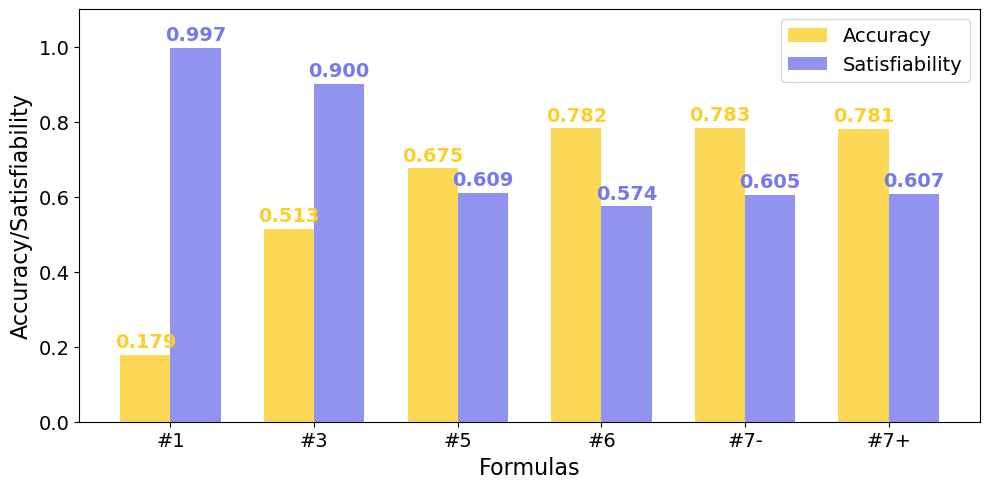

In [2]:
# plot the figure, x-axis is formula_set_name
# single y-axis showing both accuracy and satisfiability
import matplotlib.pyplot as plt

# Define the specific order for the x-axis
formula_list = ["#1", "#3", "#5", "#6", "#7-", "#7+"]

fig, ax = plt.subplots(figsize=(10, 5))

# Create positions for bars
x_pos = range(len(formula_list))
bar_width = 0.35

# Plot accuracy bars
accuracy_bars = ax.bar([i - bar_width/2 for i in x_pos], 
        [acc[f] for f in formula_list], 
        width=bar_width, color=acc["color"], alpha=0.8, label='Accuracy')

# Plot satisfiability bars
sat_bars = ax.bar([i + bar_width/2 for i in x_pos], 
        [sat[f] for f in formula_list], 
        width=bar_width, color=sat["color"], alpha=0.8, label='Satisfiability')

# Add value labels above accuracy bars
for i, f in enumerate(formula_list):
    ax.text(i - bar_width/2, acc[f] + 0.01, f'{acc[f]:.3f}', 
             ha='center', va='bottom', color=acc["color"], fontweight='bold', fontsize=tick_font_size)

# Add value labels above satisfiability bars
for i, f in enumerate(formula_list):
    ax.text(i + bar_width/2, sat[f] + 0.01, f'{sat[f]:.3f}', 
             ha='center', va='bottom', color=sat["color"], fontweight='bold', fontsize=tick_font_size)

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(formula_list, fontsize=tick_font_size)
ax.set_xlabel('Formulas', fontsize=label_font_size)
ax.set_ylabel('Accuracy/Satisfiability', fontsize=label_font_size)
ax.tick_params(axis='both', labelsize=tick_font_size)

# Add legend
ax.legend(fontsize=legend_font_size, loc='upper right')

# Set y-axis range to show full scale
ax.set_ylim(0, 1.1)

# plt.title('Accuracy and Satisfiability of Different Formula Sets', fontsize=label_font_size)

plt.tight_layout()
plt.savefig("tune_formula.pdf", dpi=300, format='pdf')
plt.show()